<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Import-&amp;-Load-data" data-toc-modified-id="Import-&amp;-Load-data-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Import &amp; Load data</a></span></li></ul></li><li><span><a href="#Separate-dataset-into-train-and-test" data-toc-modified-id="Separate-dataset-into-train-and-test-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Separate dataset into train and test</a></span></li><li><span><a href="#Target" data-toc-modified-id="Target-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Target</a></span></li><li><span><a href="#Configuration" data-toc-modified-id="Configuration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pipeline</a></span></li><li><span><a href="#Score-new-data-(test.csv)" data-toc-modified-id="Score-new-data-(test.csv)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Score new data (test.csv)</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# TMBD_Pipeline to Build a Model

### Introduction

In the previous notebooks, I cleaned data and explored dataset. 

In this notebook, I will use open source to engineer features because it is efficient when building a model and deploying the production. 

### Import & Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 100)

from pathlib import Path
import os
os.getcwd()

'/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/TMDB'

In [2]:
path = Path('/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/TMDB/datasets/')

In [3]:
from sklearn.pipeline import Pipeline 

from sklearn.preprocessing import MinMaxScaler

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer
)


from feature_engine.encoding import (
    OrdinalEncoder
)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import preprocessors as pp

import optuna
from optuna import trial

from lightgbm import LGBMRegressor
import joblib

In [4]:
df_train = pd.read_csv(path/'engineered_train.csv')
df_test = pd.read_csv(path/'engineered_test.csv')
df_train.shape, df_test.shape

((3000, 19), (4398, 18))

## Separate dataset into train and test

It is important to separate the data into training and testing set, because when we engineer features, some techniques learn parameters from data. This is to avoid over-fitting. 

Our feature engineering techniques will learn:

- mean
- mode
- log-transformation for numerical variables
- category frequency
- and category to number mappings

from the train set. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(['id', 'revenue'], axis=1),
    df_train['revenue'],
    test_size=0.2, 
    random_state=42)

X_train.shape, X_test.shape

((2400, 17), (600, 17))

## Target

We apply the logarithm

In [6]:
y_train = np.log(y_train)
y_test = np.log(y_test)

## Configuration

In order to make a pipeline, I need to determine configuration. 

In [7]:
# categorical variables with NA with set
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['num_genres', 'num_spoken_lang']

CATEGORICAL_VARS_WITH_NA_MISSING = ['num_pro_comps', 'num_keywords']


# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['budget',
                          'runtime',
                          'num_cast']

TEMPORAL_VARS = ['release_year', 'release_month', 'release_day', 'release_dayofweek']
BINARY_VARS = ['is_collection', 'is_homepage', 'is_English']

# variables to log transform
NUMERICAL_LOG_VARS = ['budget', 'popularity', 'num_cast']

# variables to map
genre = ['num_genres']
comps = ['num_pro_comps']
count = ['num_pro_count']
lang = ['num_spoken_lang']
keywords = ['num_keywords']
crew = ['num_crew']

# variables to map
genre_mappings = {'1': 1, '2': 2, '3': 3, '4': 4, '>4': 5}
comps_mappings = {'1': 1, '2': 2, '3':3, '4': 4, '5': 5, '>5': 6, 'Missing': 0}
count_mappings = {'1': 1, '2': 2, '>2': 3}
lang_mappings = {'1': 1, '2': 2, '3': 3, '>3': 4}
keywords_mappings = {'<5': 1, '<10': 2, '<15': 3, '<20': 4, '>30': 5, 'Missing': 0}
crew_mappings = {'small': 1, 'medium': 2, 'large': 3, 'missing': 0}

## Pipeline

Here, we set up missing value imputation methods, variable transformation for numerical variables, and categorical variables mappings. 

For mappings, I wrote `preprocessors.py` to create pipeline. 

Finally, I will use LightGBM Regressor to build a model. We found the best parameters for this dataset in hyperparameter tuning notebook. 

In [8]:
params = {'n_estimators': 10000,
 'num_leaves': 15,
 'boosting': 'gbdt',
 'max_depth': 5,
 'max_bin': 32,
 'min_data_in_leaf': 1,
 'min_data_in_bin': 1,
 'min_gain_to_split': 3.87,
 'learning_rate': 0.13559623067878163,
 'random_state': 0,
 'feature_fraction': 0.4629352923314487,
 'bagging_fraction': 0.8352156581622462,
 'bagging_freq': 7,
 'lambda_l1': 4.339454011245544e-08,
 'lambda_l2': 0.0031662095674507883}

In [9]:
# set up the pipeline

pipe = Pipeline([
    # ==== IMPUTATION ======
    # impute categorical variables with string missing
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)),

    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),
    
    # add missing indicator
    ('missing_indicator', AddMissingIndicator(
        variables=NUMERICAL_VARS_WITH_NA)),
    
    # impute numerical variabls with the mean
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)),
    
    
    # ===== VARIABLE TRANSFORMATION ====
    ('log', LogTransformer(variables=NUMERICAL_LOG_VARS)),
    
    
    # === mappers ===
    ('mapper_genre', pp.Mapper(
        variables=genre, mappings=genre_mappings)),
    
    ('mapper_comps', pp.Mapper(
        variables=comps, mappings=comps_mappings)),
    
    ('mapper_count', pp.Mapper(
        variables=count, mappings=count_mappings)), 
    
    ('mapper_lang', pp.Mapper(
        variables=lang, mappings=lang_mappings)),
    
    ('mapper_keywords', pp.Mapper(
        variables=keywords, mappings=keywords_mappings)),
    
    ('mapper_crew', pp.Mapper(
        variables=crew, mappings=crew_mappings)),
    
    # ===== Feature Scaling =======
    ('scaler', MinMaxScaler()),
    
    ('lgb', LGBMRegressor(n_jobs=-1, **params))
])

In [10]:
# train the pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['num_pro_comps',
                                               'num_keywords'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['num_genres',
                                               'num_spoken_lang'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['budget', 'runtime',
                                                'num_cast'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation...
                ('lgb',
                 LGBMRegressor(bagging_fraction=0.8352156581622462,
                               bagging_freq=7, boosting='gbdt',
                               feature_fraction=0.4629352923314487,
                               lambda_l1=4.339454011245544e-08,
                               lambda_l2=0.003166209

In [11]:

# make predictions for train set
pred = pipe.predict(X_train)

# rmse
print('train rmse: {}'.format(mean_squared_error(y_train, pred, squared=False)))


# make predictions for test set
pred_test = pipe.predict(X_test)

# rmse
print('test rmse: {}'.format(mean_squared_error(y_test, pred_test, squared=False)))


train rmse: 1.7075463132310413
test rmse: 1.981864758237628


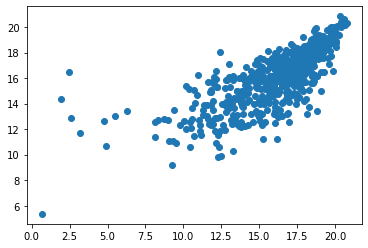

In [12]:
plt.scatter(y_test, pipe.predict(X_test))


In [13]:
# now let's save the pipe
joblib.dump(pipe, path/'tmbd_pipe.joblib')

['/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/TMDB/datasets/tmbd_pipe.joblib']

## Score new data (test.csv)

We created pipeline to build lgb model, and now we can use the model to predict revenue for new data (test.csv)

In [14]:
df_test.head(2)

,id,budget,popularity,runtime,is_collection,num_genres,is_homepage,is_English,num_pro_comps,num_pro_count,num_spoken_lang,num_keywords,num_cast,num_crew,release_month,release_day,release_year,release_dayofweek
0,3001,NaN,3.851534,90.0,1,4,1,0,NaN,2,2,<5,7.0,small,7.0,14.0,2007.0,5.0
1,3002,88000.0,3.559789,65.0,0,2,0,1,1,1,1,<10,10.0,small,5.0,19.0,1958.0,6.0


There is a situation where we don't have any missing values in certain variables in training set, but we have missing observations in test set. 

In [15]:
# create a list of missing values for test set
new_vars_with_na = [var for var in X_train.columns
                   if var not in CATEGORICAL_VARS_WITH_NA_FREQUENT + 
                   CATEGORICAL_VARS_WITH_NA_MISSING +
                   NUMERICAL_VARS_WITH_NA
                   and df_test[var].isnull().mean()>0]

new_vars_with_na

['release_month', 'release_day', 'release_year', 'release_dayofweek']

In [16]:
df_test[new_vars_with_na].isnull().mean()

release_month        0.000227
release_day          0.000227
release_year         0.000227
release_dayofweek    0.000227
dtype: float64

As we can see that the missing observations in test set are negligible, so I would impute missing values with median of training set.

In [17]:
### ==== Add missing imputation method for test set=====
# categorical variables with NA with set
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['num_genres', 'num_spoken_lang']

CATEGORICAL_VARS_WITH_NA_MISSING = ['num_pro_comps', 'num_keywords']


# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['budget',
                          'runtime',
                          'num_cast']

# config for test set
NEW_VARS_WITH_NA = ['release_year', 'release_month', 'release_day', 'release_dayofweek']

# temporal and binary variables
TEMPORAL_VARS = ['release_year', 'release_month', 'release_day', 'release_dayofweek']
BINARY_VARS = ['is_collection', 'is_homepage', 'is_English']

# variables to log transform
NUMERICAL_LOG_VARS = ['budget', 'popularity', 'num_cast']

# variables to map
genre = ['num_genres']
comps = ['num_pro_comps']
count = ['num_pro_count']
lang = ['num_spoken_lang']
keywords = ['num_keywords']
crew = ['num_crew']

# variables to map
genre_mappings = {'1': 1, '2': 2, '3': 3, '4': 4, '>4': 5}
comps_mappings = {'1': 1, '2': 2, '3':3, '4': 4, '5': 5, '>5': 6, 'Missing': 0}
count_mappings = {'1': 1, '2': 2, '>2': 3}
lang_mappings = {'1': 1, '2': 2, '3': 3, '>3': 4}
keywords_mappings = {'<5': 1, '<10': 2, '<15': 3, '<20': 4, '>30': 5, 'Missing': 0}
crew_mappings = {'small': 1, 'medium': 2, 'large': 3, 'missing': 0}

In [18]:
# set up the pipeline

pipe = Pipeline([
    # ==== IMPUTATION ======
    # impute categorical variables with string missing
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)),

    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),
    
    # add missing indicator
    ('missing_indicator', AddMissingIndicator(
        variables=NUMERICAL_VARS_WITH_NA)),
    
    # impute numerical variabls with the mean
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)),
    
    # impute missing values with the median for testing set
    ('median_imputation', MeanMedianImputer(
        imputation_method='median', variables=NEW_VARS_WITH_NA)),
    
    
    # ===== VARIABLE TRANSFORMATION ====
    ('log', LogTransformer(variables=NUMERICAL_LOG_VARS)),
    
    
    # === mappers ===
    ('mapper_genre', pp.Mapper(
        variables=genre, mappings=genre_mappings)),
    
    ('mapper_comps', pp.Mapper(
        variables=comps, mappings=comps_mappings)),
    
    ('mapper_count', pp.Mapper(
        variables=count, mappings=count_mappings)), 
    
    ('mapper_lang', pp.Mapper(
        variables=lang, mappings=lang_mappings)),
    
    ('mapper_keywords', pp.Mapper(
        variables=keywords, mappings=keywords_mappings)),
    
    ('mapper_crew', pp.Mapper(
        variables=crew, mappings=crew_mappings)),
    
    # ===== Feature Scaling =======
    ('scaler', MinMaxScaler()),
    
    ('lgb', LGBMRegressor(n_jobs=-1, **params))
])

In [19]:
# train the pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['num_pro_comps',
                                               'num_keywords'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['num_genres',
                                               'num_spoken_lang'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['budget', 'runtime',
                                                'num_cast'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation...
                ('lgb',
                 LGBMRegressor(bagging_fraction=0.8352156581622462,
                               bagging_freq=7, boosting='gbdt',
                               feature_fraction=0.4629352923314487,
                               lambda_l1=4.339454011245544e-08,
                               lambda_l2=0.003166209

In [20]:
# make predictions for train set
pred = pipe.predict(X_train)

# rmse
print('train rmse: {}'.format(mean_squared_error(y_train, pred, squared=False)))


# make predictions for test set
pred_test = pipe.predict(X_test)

# rmse
print('test rmse: {}'.format(mean_squared_error(y_test, pred_test, squared=False)))

train rmse: 1.7075463132310413
test rmse: 1.981864758237628


In [21]:
new_preds = pipe.predict(df_test.drop(['id'], axis=1))

<AxesSubplot:>

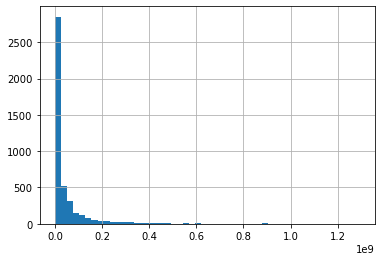

In [22]:
# let's plot the predicted revenue of movies
pd.Series(np.exp(new_preds)).hist(bins=50)

When submitted the predicted values for test set, I got 2.06 rmse in Kaggle (580th). I might be able to try to get a better model, but it is not my primary purpose of this project. Therefore, I will use this model to deploy the production. 

## Conclusion

Now we are ready for deployment!